In [1]:
# Import modules
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical



In [2]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My Drive/Images1/'

print(os.listdir(BASE_DIR))

Mounted at /content/drive
['1003163366_44323f5815.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1000268201_693b08cb0e.jpg', '101669240_b2d3e7f17b.jpg', '1012212859_01547e3f17.jpg', '1016887272_03199f49c4.jpg', '1007129816_e794419615.jpg', '1015584366_dfcec3c85a.jpg', '101654506_8eb26cfb60.jpg', '1009434119_febe49276a.jpg', '1007320043_627395c3d8.jpg', '1015118661_980735411b.jpg', '1022454428_b6b660a67b.jpg', '1019604187_d087bf9a5f.jpg', '1022975728_75515238d8.jpg', '102351840_323e3de834.jpg', '1020651753_06077ec457.jpg', '1019077836_6fc9b15408.jpg', '1022454332_6af2c1449a.jpg', '103106960_e8a41d64f8.jpg', '1028205764_7e8df9a2ea.jpg', '1026685415_0431cbf574.jpg', '103205630_682ca7285b.jpg', '1032122270_ea6f0beedb.jpg', '1030985833_b0902ea560.jpg', '103195344_5d2dc613a3.jpg', '102455176_5f8ead62d5.jpg', '1032460886_4a598ed535.jpg', '1034276567_49bb87c51c.jpg', '1024138940_f1fefbdce1.jpg', '1055753357_4fa3d8d693.jpg', '1052358063_eae6744153.jpg', '1053804096_ad278b25f1.

In [3]:
# BASE_DIR = '/Images'
WORKING_DIR = '/working'

##Extract Image Features

In [4]:
#load vgg16 model
model = VGG16()
#restructure model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
# Extract features from image
features = {}
# directory = os.path.join(BASE_DIR, 'Images1')

for img_name in tqdm(os.listdir(BASE_DIR)):
    # load image from file
    img_path = os.path.join(BASE_DIR, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

features

  0%|          | 0/400 [00:00<?, ?it/s]

{'1003163366_44323f5815': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 '1001773457_577c3a7d70': array([[0.        , 0.        , 0.49414605, ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 '1002674143_1b742ab4b8': array([[1.4937943, 0.       , 0.5356754, ..., 2.3152385, 3.7418268,
         0.       ]], dtype=float32),
 '1000268201_693b08cb0e': array([[2.5074759, 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '101669240_b2d3e7f17b': array([[1.1132066, 0.       , 0.       , ..., 0.       , 6.978065 ,
         1.1585557]], dtype=float32),
 '1012212859_01547e3f17': array([[0.        , 0.        , 0.98737204, ..., 0.        , 1.4932482 ,
         0.86128676]], dtype=float32),
 '1016887272_03199f49c4': array([[0.74992204, 0.        , 0.        , ..., 0.        , 2.3006256 ,
         0.02373368]], dtype=float32),
 '1007129816_e794419615': array([[0.        , 0.0922772 , 0.        , ..., 0.        , 0.        ,
         0.

In [6]:
# features.shape()

In [7]:
# store feature in pickle
pickle.dump(features, open(os.path.join('features.pkl'), 'wb'))

In [8]:
# load the caption
with open(os.path.join('captions 2.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()

In [9]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .,\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .,\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .,\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .,\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .,\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .,\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .,\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .,\n1002674143_1

In [10]:
#create mapping of image to captions
mapping = {}
#process the lines
for line in tqdm(captions_doc.split('\n')):
  #split the line by comma
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  #remove extension from image ID
  image_id = image_id.split('.')[0]
  # convert caption list to string
  caption = " ".join(caption)
  #create list if needed
  if image_id not in mapping:
    mapping[image_id] = []
  #store the caption
  mapping[image_id].append(caption)

  0%|          | 0/1731 [00:00<?, ?it/s]

In [11]:
len(mapping)
mapping

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way . ',
  'A girl going into a wooden building . ',
  'A little girl climbing into a wooden playhouse . ',
  'A little girl climbing the stairs to her playhouse . ',
  'A little girl in a pink dress going into a wooden cabin . '],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting ',
  'A black dog and a tri-colored dog playing with each other on the road . ',
  'A black dog and a white dog with brown spots are staring at each other in the street . ',
  'Two dogs of different breeds looking at each other on the road . ',
  'Two dogs on pavement moving toward each other . '],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . ',
  'A little girl is sitting in front of a large painted rainbow . ',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . ',
  '

In [12]:
def cleaning(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      #take one caption at a time
      caption = captions[i]
      #preprocessing steps
      #convert to lowercase
      caption = caption.lower()
      #delete digits, special chars, etc.,
      caption = caption.replace('[^A-Za-z]', '')
      #delete additional spaces
      caption = caption.replace('\s+', ' ')
      #add start and end tags to the caption
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
      captions[i] = caption
  return mapping


In [13]:
print(mapping.keys())

dict_keys(['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615', '1007320043_627395c3d8', '1009434119_febe49276a', '1012212859_01547e3f17', '1015118661_980735411b', '1015584366_dfcec3c85a', '101654506_8eb26cfb60', '101669240_b2d3e7f17b', '1016887272_03199f49c4', '1019077836_6fc9b15408', '1019604187_d087bf9a5f', '1020651753_06077ec457', '1022454332_6af2c1449a', '1022454428_b6b660a67b', '1022975728_75515238d8', '102351840_323e3de834', '1024138940_f1fefbdce1', '102455176_5f8ead62d5', '1026685415_0431cbf574', '1028205764_7e8df9a2ea', '1030985833_b0902ea560', '103106960_e8a41d64f8', '103195344_5d2dc613a3', '103205630_682ca7285b', '1032122270_ea6f0beedb', '1032460886_4a598ed535', '1034276567_49bb87c51c', '104136873_5b5d41be75', '1042020065_fb3d3ba5ba', '1042590306_95dea0916c', '1045521051_108ebc19be', '1048710776_bb5b0a5c7c', '1052358063_eae6744153', '105342180_4d4a40b47f', '1053804096_ad278b25f1', '1055623002_8195a43714'

In [14]:
#before preprocess
mapping['1121416483_c7902d0d49']

['A child is standing on her head . ',
 'A little girl standing on her head . ',
 'A small child doing a handstand on a bed . ',
 'A young girl does a handstand on a bed with blue sheets . ',
 'The girl is upside down on a bed ']

In [15]:
# preprocess
cleaning(mapping)

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tri-colored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow ends

In [16]:
# after preprocess
mapping["1358089136_976e3d2e30"]

['startseq boy sand surfing down hill endseq',
 'startseq man is attempting to surf down hill made of sand on sunny day endseq',
 'startseq man is sliding down huge sand dune on sunny day endseq',
 'startseq man is surfing down hill of sand endseq',
 'startseq young man in shorts and t-shirt is snowboarding under bright blue sky endseq']

In [17]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:  # Correct way to access dictionary values
        all_captions.append(caption)

mapping

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tri-colored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow ends

In [18]:
len(all_captions)

1730

In [19]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
vocab_size

1731

In [22]:
# get maximum length of the caption
max_length = max(len(caption.split()) for caption in all_captions)
max_length

29

In [23]:
# Train and Test split
image_ids = list(mapping.keys())
print(image_ids)
split = int(len(image_ids) * 0.90)
print(split)
train = image_ids[:split]
test = image_ids[split:]

print('<--------------------------------------------->')
print(train)
print('<--------------------------------------------->')
print(test)

['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615', '1007320043_627395c3d8', '1009434119_febe49276a', '1012212859_01547e3f17', '1015118661_980735411b', '1015584366_dfcec3c85a', '101654506_8eb26cfb60', '101669240_b2d3e7f17b', '1016887272_03199f49c4', '1019077836_6fc9b15408', '1019604187_d087bf9a5f', '1020651753_06077ec457', '1022454332_6af2c1449a', '1022454428_b6b660a67b', '1022975728_75515238d8', '102351840_323e3de834', '1024138940_f1fefbdce1', '102455176_5f8ead62d5', '1026685415_0431cbf574', '1028205764_7e8df9a2ea', '1030985833_b0902ea560', '103106960_e8a41d64f8', '103195344_5d2dc613a3', '103205630_682ca7285b', '1032122270_ea6f0beedb', '1032460886_4a598ed535', '1034276567_49bb87c51c', '104136873_5b5d41be75', '1042020065_fb3d3ba5ba', '1042590306_95dea0916c', '1045521051_108ebc19be', '1048710776_bb5b0a5c7c', '1052358063_eae6744153', '105342180_4d4a40b47f', '1053804096_ad278b25f1', '1055623002_8195a43714', '1055753

##Model Creation

In [25]:
def generate_data(data_keys, mappings, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    x1, x2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mappings[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into x, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen = max_length, padding='post')[0] # Pad sequences at the end
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]

                    # store the sequences
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
              x1, x2, y = np.array(x1), np.array(x2), np.array(y)
              # Yield data in the expected nested tuple structure
              yield ((x1, x2), y)
              x1, x2, y = list(), list(), list()
              n = 0

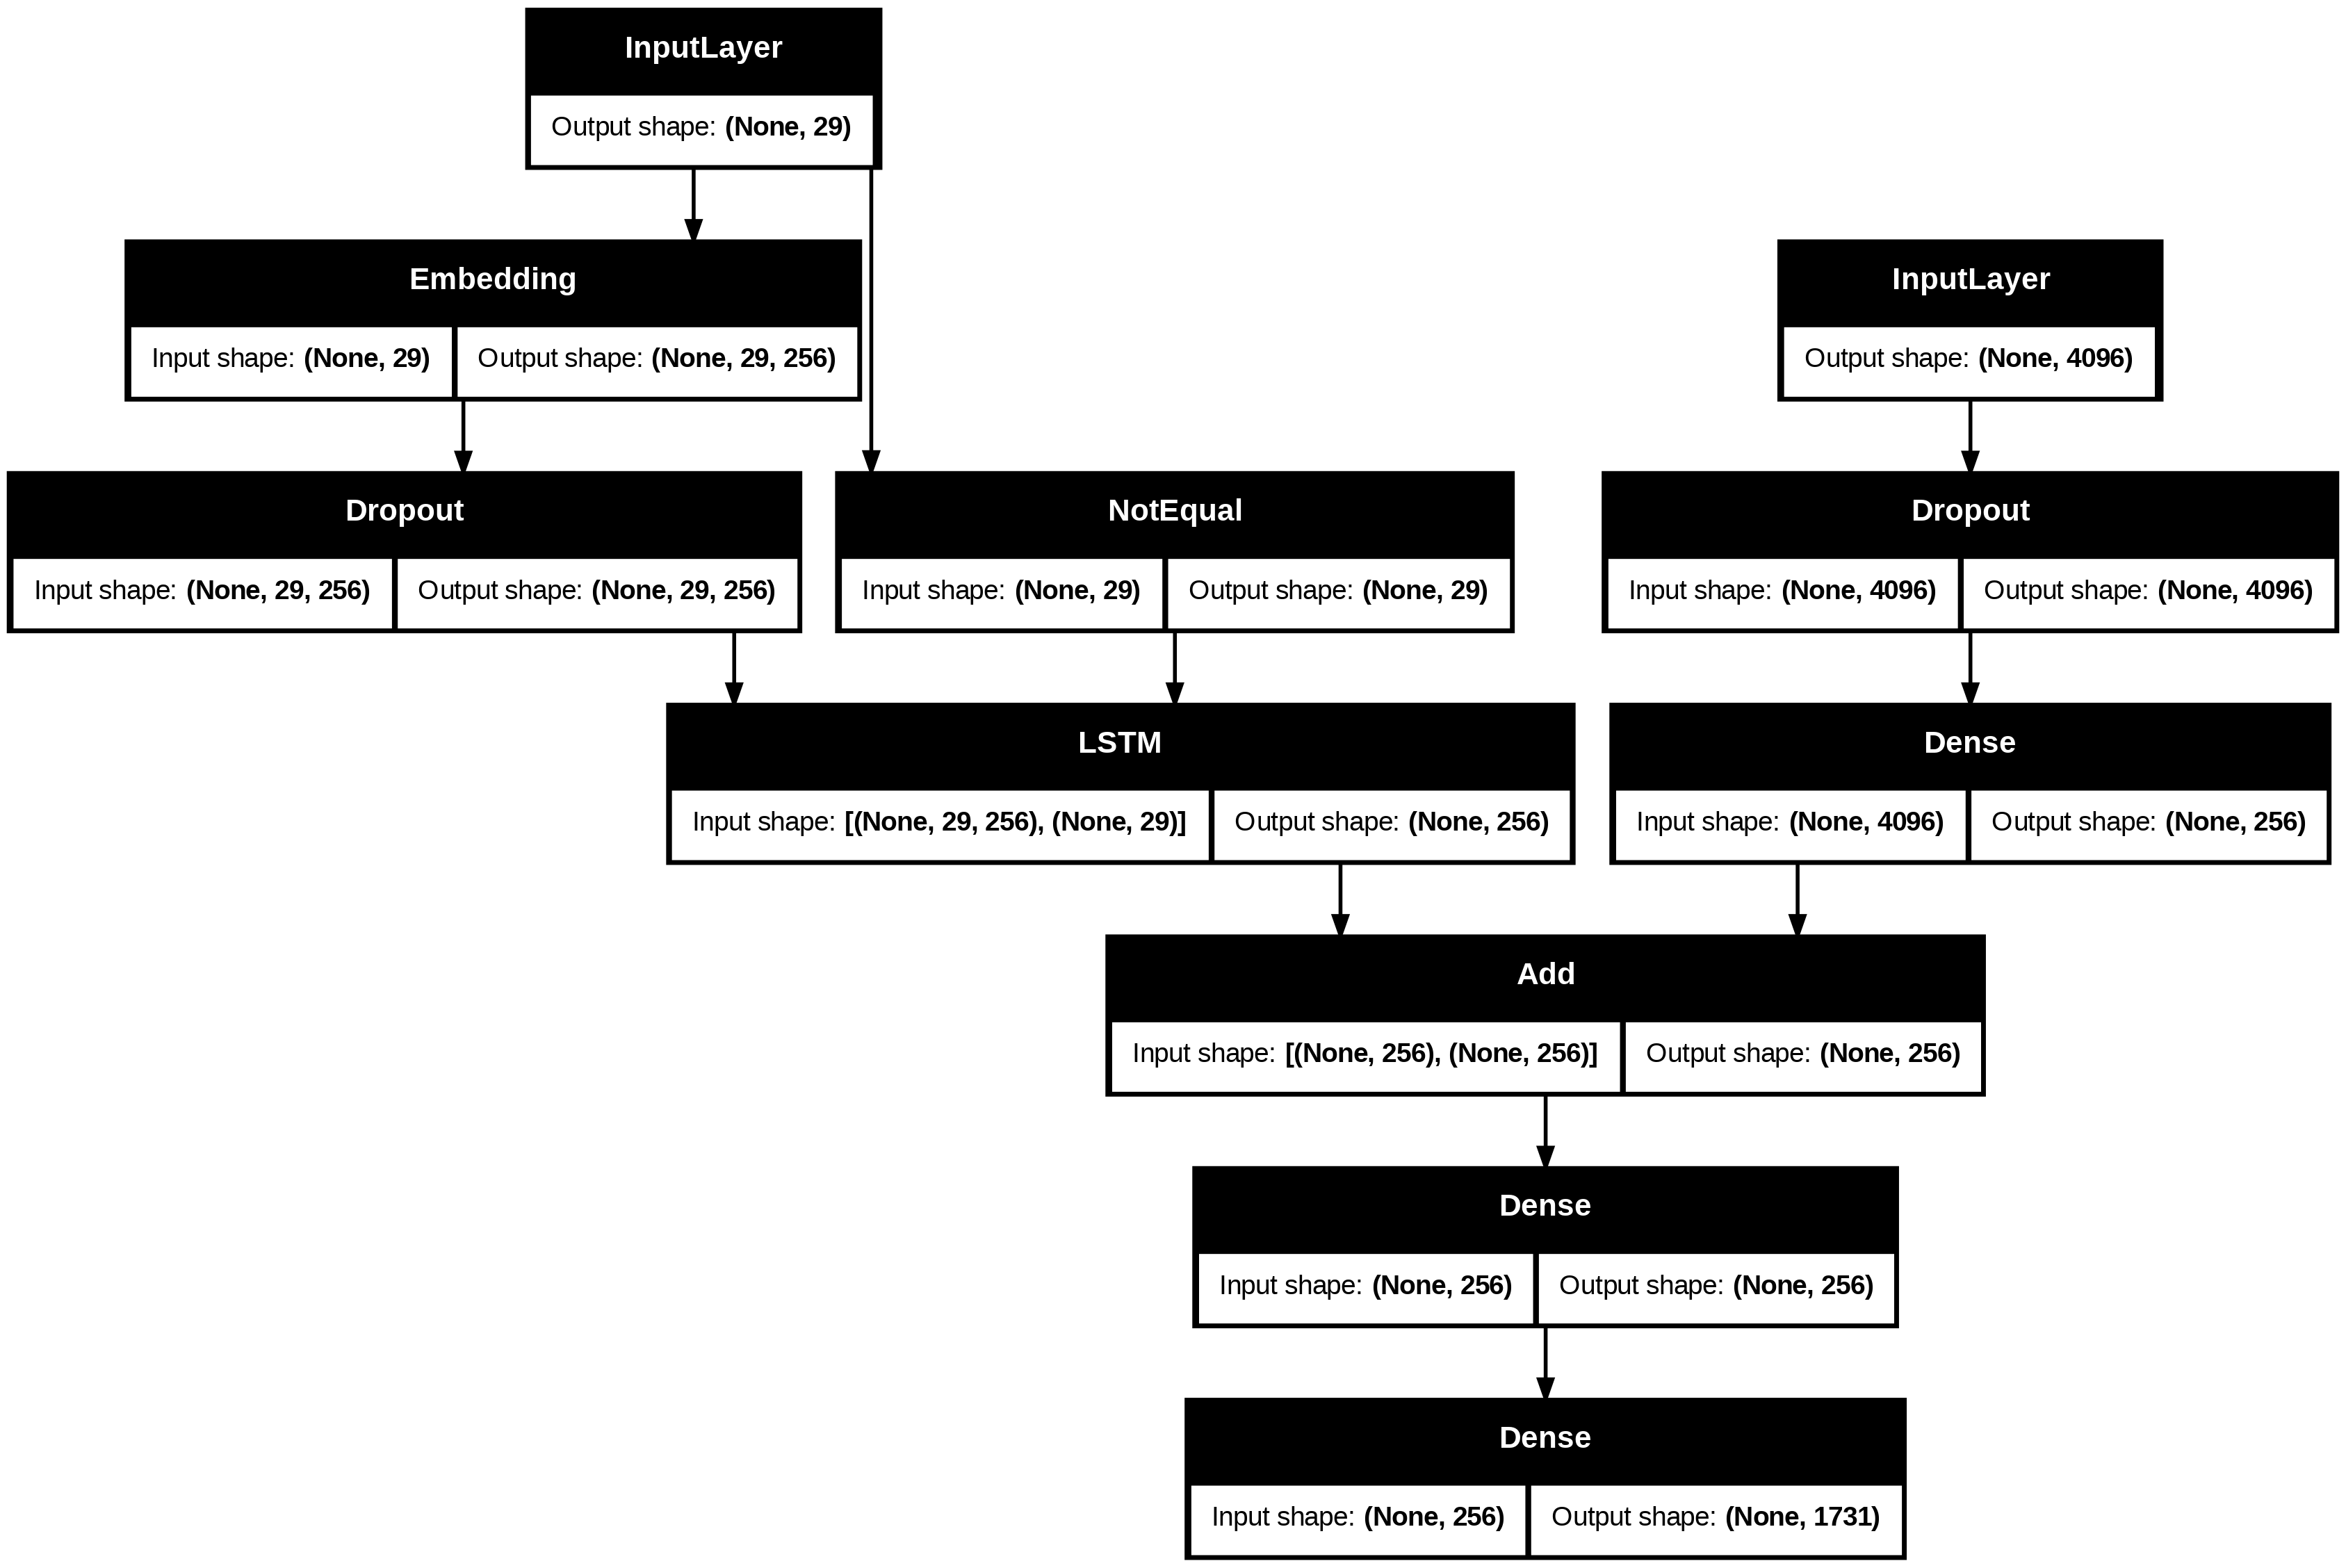

In [27]:

#ENCODER MODEL

# image feature layers
inputs1 = Input(shape = (4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

# sequence feature layers
inputs2 = Input(shape = (max_length,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# DECODER MODEL

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

#plot the model
plot_model(model, show_shapes = True)

In [63]:
import tensorflow as tf

epochs = 50
batch_size = 32
steps = len(train) // batch_size

# Update output_signature to match the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  # x1
        tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)  # x2
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y
)

dataset = tf.data.Dataset.from_generator(
    lambda: generate_data(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    output_signature=output_signature
)

for i in range(epochs):
    model.fit(dataset, epochs=1, steps_per_epoch=steps, verbose=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.4534
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.4377
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 0.4332
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.4266
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.4273
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.4065
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.4214
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.4005
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.4040
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 0.3918
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.3788
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.3744
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.3678
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.3590
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.3598
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.3623
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.3568
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.3509
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [64]:

# to save the model
model.save(WORKING_DIR+'/best_model.h5')

#Generate captions for Images

In [65]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def int_to_word(index, tokenizer):
    for word, i in tokenizer.word_index.items():
        if i == index:
            return word
    return None


## Visualize the Results

---------------------Actual---------------------
startseq man drilling hole in the ice endseq
startseq man is drilling through the frozen ice of pond endseq
startseq person in the snow drilling hole in the ice endseq
startseq person standing on frozen lake endseq
startseq two men are ice fishing endseq
--------------------Predicted--------------------
startseq person in the snow drilling hole in the ice endseq


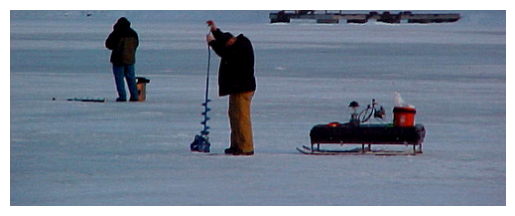

In [70]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def generate_caption_for_image(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = int_to_word(yhat, tokenizer)  # Assuming ind_to_word is defined
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

def generate_caption(image_name):
    # Load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(image_name)
    image = Image.open(img_path)

    # Display actual captions
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # Predict the caption using the model
    y_pred = generate_caption_for_image(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

    # Show the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Call the function with an image file name
generate_caption('102351840_323e3de834.jpg')


In [71]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get actual captions
    captions = mapping[key]  # This is already a list of strings
    # Predict the caption for the image
    y_pred = generate_caption_for_image(model, features[key], tokenizer, max_length)
    # Split the predicted caption into words
    y_pred = y_pred.split()
    # Append the actual captions and predicted caption to their respective lists
    actual.append([caption.split() for caption in captions])
    predicted.append(y_pred)

# Calculate the BLEU score
print("\nBLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]


BLEU-1: 0.506112
BLEU-2: 0.284947
